In [79]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/nlp-getting-started/sample_submission.csv


# Description 
Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

But, it’s not always clear whether a person’s words are actually announcing a disaster. 

The author explicitly uses the word “ABLAZE” but means it metaphorically. This is clear to a human right away, especially with the visual aid. But it’s less clear to a machine.

In this competition, you’re challenged to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. You’ll have access to a dataset of 10,000 tweets that were hand classified. If this is your first time working on an NLP problem, we've created a quick tutorial to get you up and running.

Disclaimer: The dataset for this competition contains text that may be considered profane, vulgar, or offensive.

## Dataset
This dataset was created by the company figure-eight and originally shared on their ‘Data For Everyone’ website here. <br>
https://www.figure-eight.com/data-for-everyone/

## Columns

* id - a unique identifier for each tweet
* text - the text of the tweet
* location - the location the tweet was sent from (may be blank)
* keyword - a particular keyword from the tweet (may be blank)
* target - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

Each sample in the train and test set has the following information:

- The text of a tweet
- A keyword from that tweet (although this may be blank!)
- The location the tweet was sent from (may also be blank)

# 1. Import packages

In [80]:
# Basic packages -> Already declared
# import numpy as np 
# import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Natural Language Processing packages
import nltk
from nltk.corpus import stopwords
import string as s
import re
# Vectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
# ML packages
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV,StratifiedKFold,RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
# Evaluation pacakges
from sklearn.metrics import f1_score

# 2. Read the data sets

In [81]:
train = pd.read_csv('../input/nlp-getting-started/train.csv')
test = pd.read_csv('../input/nlp-getting-started/test.csv')

# 3. Explorary Data Analysis (EDA)

## Checking the overview of data

In [82]:
train.shape

(7613, 5)

In [83]:
test.shape

(3263, 4)

In [84]:
train.dtypes

id           int64
keyword     object
location    object
text        object
target       int64
dtype: object

In [85]:
test.dtypes

id           int64
keyword     object
location    object
text        object
dtype: object

In [86]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
id          7613 non-null int64
keyword     7552 non-null object
location    5080 non-null object
text        7613 non-null object
target      7613 non-null int64
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [87]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
id          3263 non-null int64
keyword     3237 non-null object
location    2158 non-null object
text        3263 non-null object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [88]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [89]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [90]:
train['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

## Data visualization

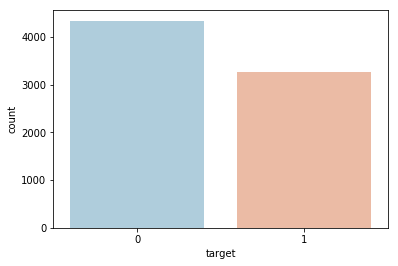

In [91]:
sns.countplot(x='target',data=train,palette='RdBu_r')

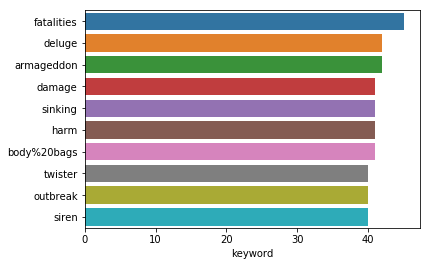

In [92]:
sns.barplot(y=train['keyword'].value_counts()[:10].index,x=train['keyword'].value_counts()[:10],orient='h')

In [93]:
train['location'].value_counts()

USA                           104
New York                       71
United States                  50
London                         45
Canada                         29
                             ... 
316                             1
We're All Mad Here              1
Bangor, Co.Down                 1
prob turning up with sheen      1
Shah Alam,Malaysia              1
Name: location, Length: 3341, dtype: int64

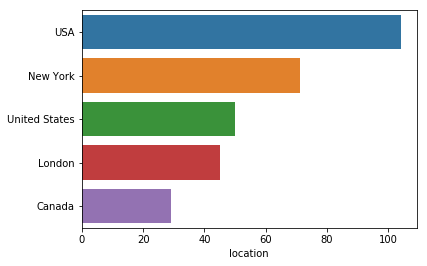

In [94]:
sns.barplot(y=train['location'].value_counts()[:5].index,x=train['location'].value_counts()[:5],orient='h')

## Checking missing values
The missing values are converted to Python's default. We use Python's built-in functions to identify these missing values. There are two methods to detect missing data:

- .isnull()
- .notnull()

In [95]:
pd.isnull(train).any()

id          False
keyword      True
location     True
text        False
target      False
dtype: bool

In [96]:
pd.isnull(train).sum() # check the missing values

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

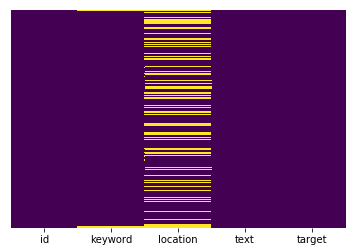

In [97]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

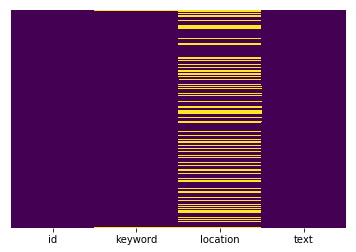

In [98]:
sns.heatmap(test.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [99]:
import missingno as msno

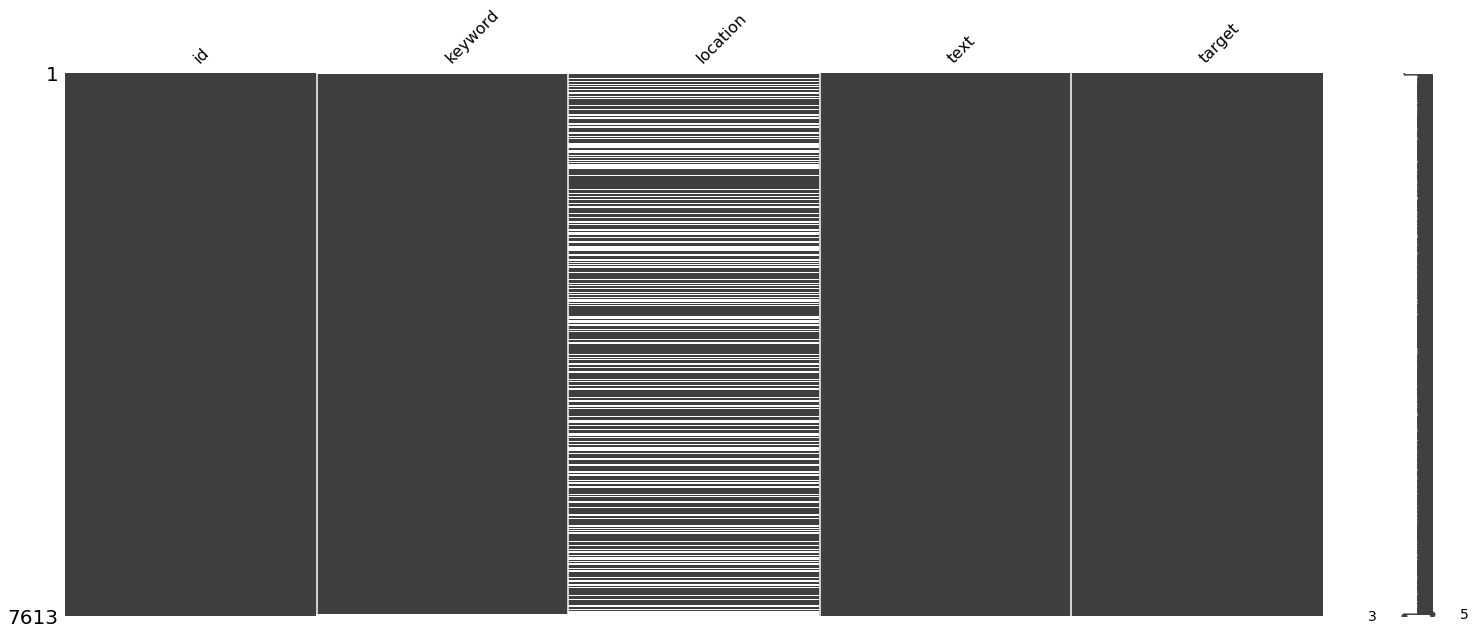

In [100]:
msno.matrix(train)

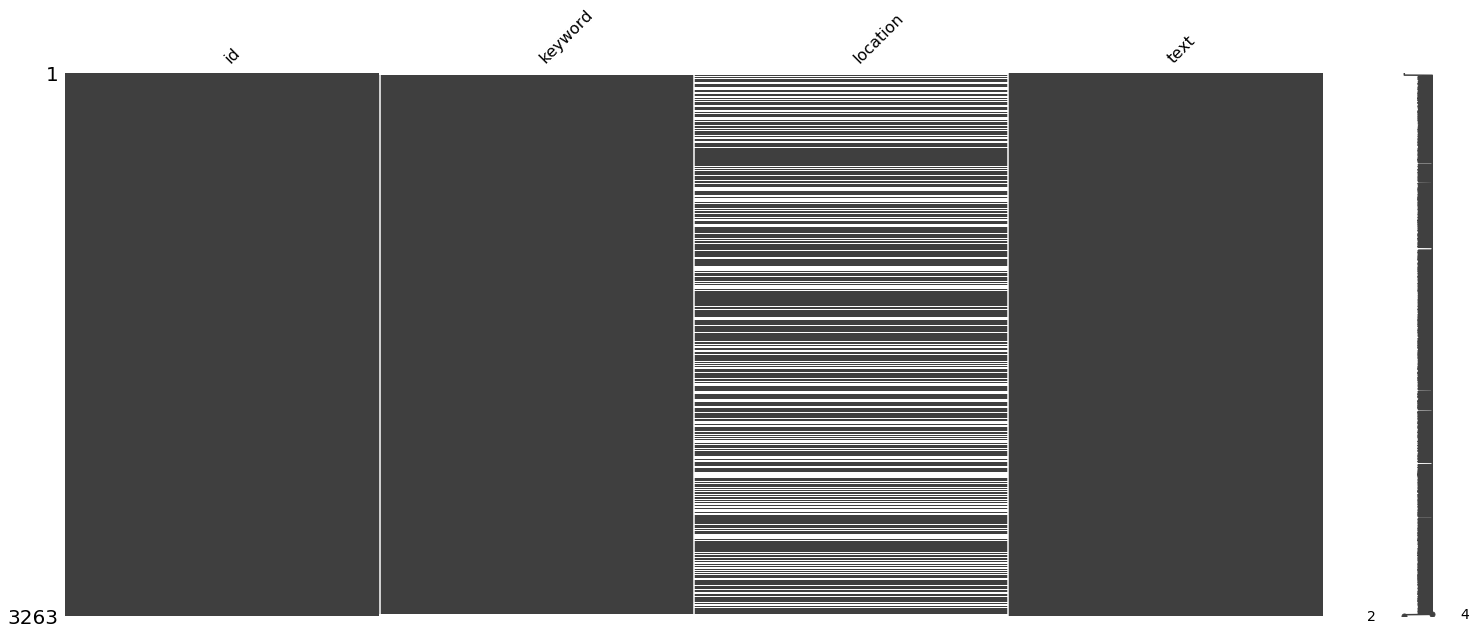

In [101]:
msno.matrix(test)

In [102]:
# Check which variables have missing values

columns_with_missing_values = train.columns[train.isnull().any()]
train[columns_with_missing_values].isnull().sum()

keyword       61
location    2533
dtype: int64

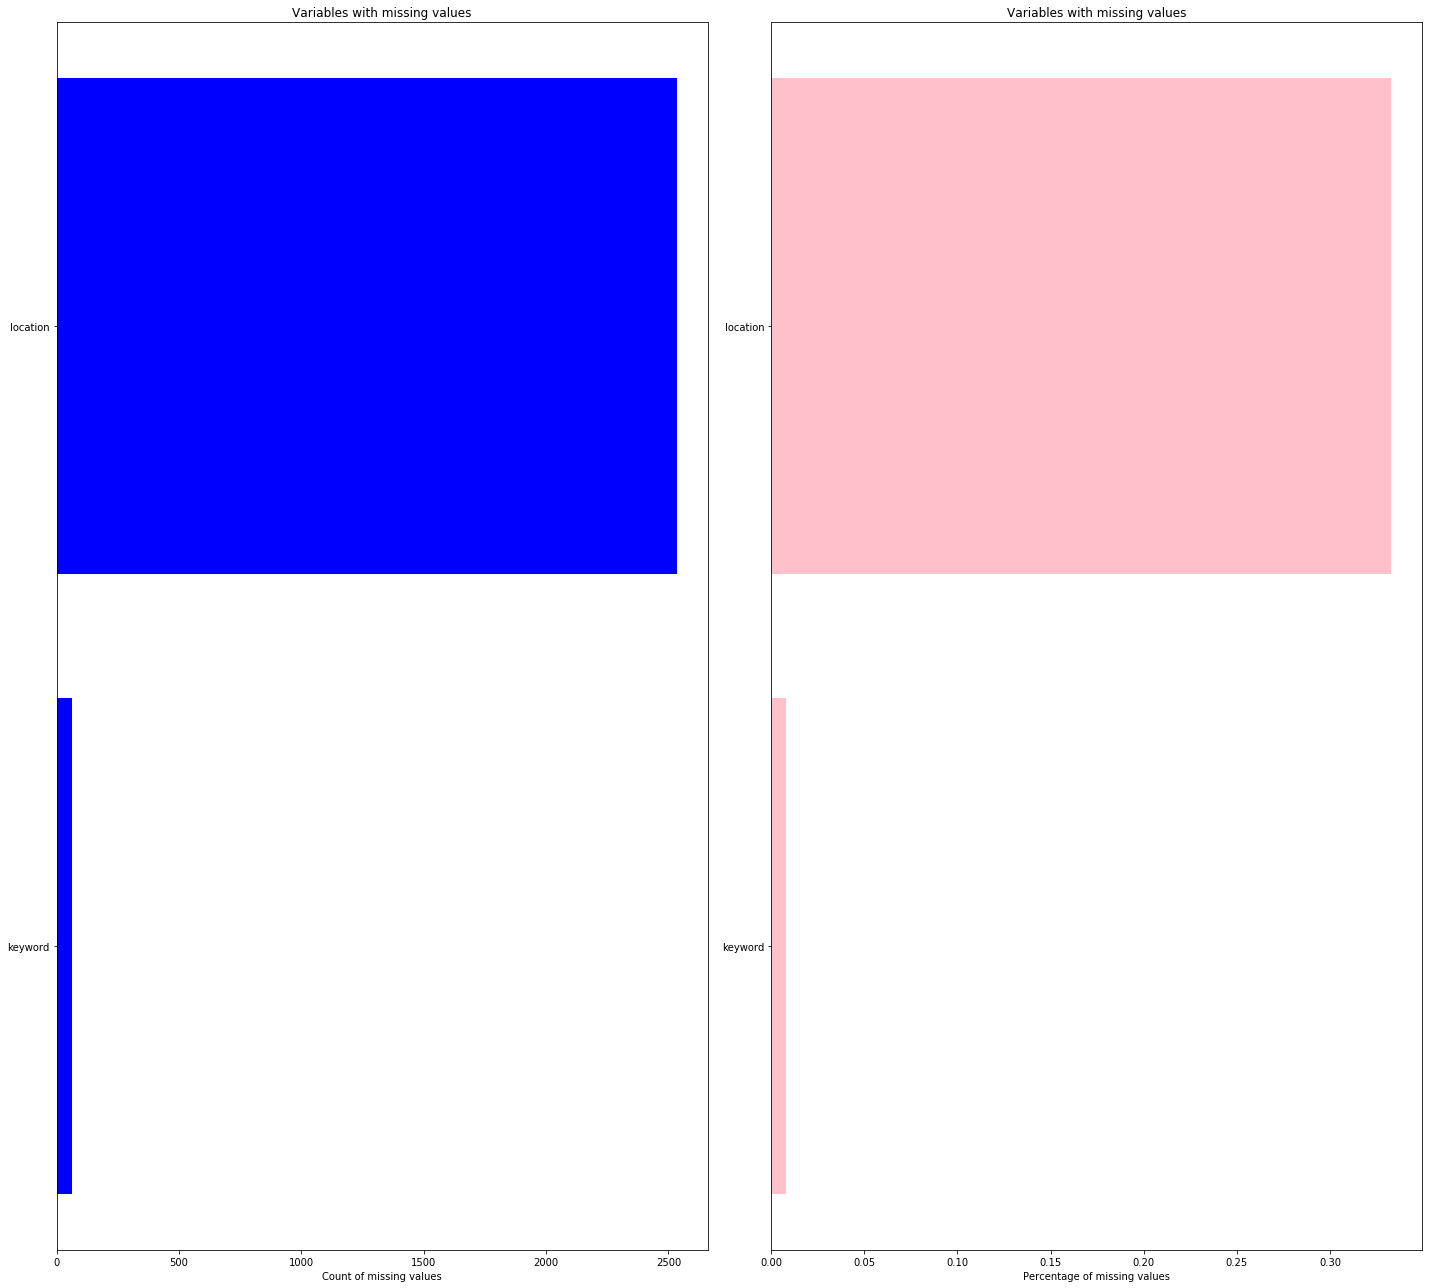

In [103]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# To hold variable names
labels = [] 

# To hold the count of missing values for each variable 
valuecount = [] 

# To hold the percentage of missing values for each variable
percentcount = [] 

for col in columns_with_missing_values:
    labels.append(col)
    valuecount.append(train[col].isnull().sum())
    # crystallizer.shape[0] will give the total row count
    percentcount.append(train[col].isnull().sum()/train.shape[0])

ind = np.arange(len(labels))

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,18))

rects = ax1.barh(ind, np.array(valuecount), color='blue')
ax1.set_yticks(ind)
ax1.set_yticklabels(labels, rotation='horizontal')
ax1.set_xlabel("Count of missing values")
ax1.set_title("Variables with missing values")

rects = ax2.barh(ind, np.array(percentcount), color='pink')
ax2.set_yticks(ind)
ax2.set_yticklabels(labels, rotation='horizontal')
ax2.set_xlabel("Percentage of missing values")
ax2.set_title("Variables with missing values")
plt.tight_layout()

In [104]:
# Check which variables have missing values

columns_with_missing_values = test.columns[test.isnull().any()]
test[columns_with_missing_values].isnull().sum()

keyword       26
location    1105
dtype: int64

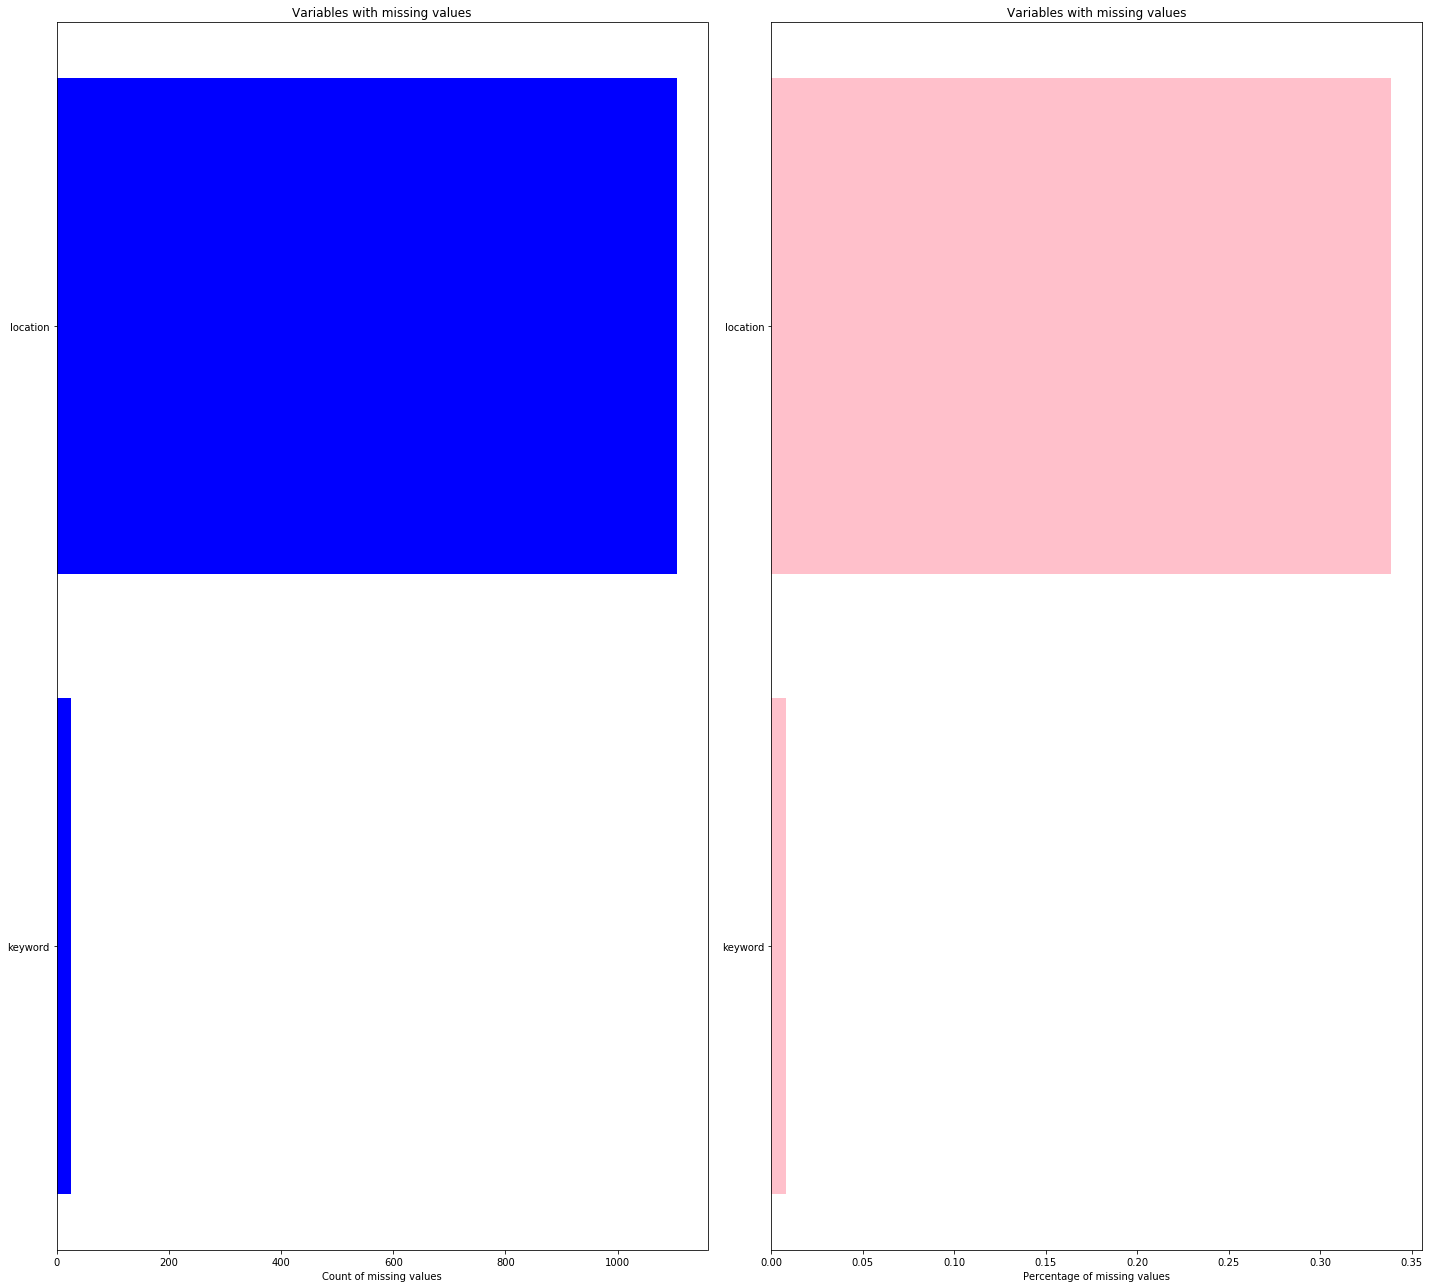

In [105]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# To hold variable names
labels = [] 

# To hold the count of missing values for each variable 
valuecount = [] 

# To hold the percentage of missing values for each variable
percentcount = [] 

for col in columns_with_missing_values:
    labels.append(col)
    valuecount.append(test[col].isnull().sum())
    # crystallizer.shape[0] will give the total row count
    percentcount.append(test[col].isnull().sum()/test.shape[0])

ind = np.arange(len(labels))

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,18))

rects = ax1.barh(ind, np.array(valuecount), color='blue')
ax1.set_yticks(ind)
ax1.set_yticklabels(labels, rotation='horizontal')
ax1.set_xlabel("Count of missing values")
ax1.set_title("Variables with missing values")

rects = ax2.barh(ind, np.array(percentcount), color='pink')
ax2.set_yticks(ind)
ax2.set_yticklabels(labels, rotation='horizontal')
ax2.set_xlabel("Percentage of missing values")
ax2.set_title("Variables with missing values")
plt.tight_layout()

- Train dataset has 
keyword       61 and 
location    2533
- Test dataset has
keyword       26 and
location    1105

## In this section, I show the easiest way to explore the dataset using pandas-profiling.

In [106]:
!pip install pandas-profiling[notebook,html]

In [107]:
from pandas_profiling import ProfileReport
profile = ProfileReport(train)

In [108]:
profile

# Data Preprocessing
Now we are done in data exploration and go to data preprocessing steps!!

There are several steps to handle the text data.
1. Sentence & Word tokenization
2. Handling all lower case, stopwords, puntuations
3. Stopwords,Punctuation
4. Stemming and Lemmatization
5. Chunking,Chinking and POS tagging

After test preprocessing, we are ready to explore the data and predict our target. Let's handle the text!!!

## Tokenization

In [109]:
def tokenization(text):
    word = text.split()
    return word
train['text'] = train['text'].apply(tokenization)
test['text'] = test['text'].apply(tokenization)

In [110]:
train['text']

0       [Our, Deeds, are, the, Reason, of, this, #eart...
1          [Forest, fire, near, La, Ronge, Sask., Canada]
2       [All, residents, asked, to, 'shelter, in, plac...
3       [13,000, people, receive, #wildfires, evacuati...
4       [Just, got, sent, this, photo, from, Ruby, #Al...
                              ...                        
7608    [Two, giant, cranes, holding, a, bridge, colla...
7609    [@aria_ahrary, @TheTawniest, The, out, of, con...
7610    [M1.94, [01:04, UTC]?5km, S, of, Volcano, Hawa...
7611    [Police, investigating, after, an, e-bike, col...
7612    [The, Latest:, More, Homes, Razed, by, Norther...
Name: text, Length: 7613, dtype: object

## Handle Lowercase

In [111]:
def lowercase(word):
    new_word = list()
    for i in word:
        i = i.lower()
        new_word.append(i)
    return new_word
train['text'] = train['text'].apply(lowercase)
test['text'] = test['text'].apply(lowercase)    

In [112]:
train['text'] 

0       [our, deeds, are, the, reason, of, this, #eart...
1          [forest, fire, near, la, ronge, sask., canada]
2       [all, residents, asked, to, 'shelter, in, plac...
3       [13,000, people, receive, #wildfires, evacuati...
4       [just, got, sent, this, photo, from, ruby, #al...
                              ...                        
7608    [two, giant, cranes, holding, a, bridge, colla...
7609    [@aria_ahrary, @thetawniest, the, out, of, con...
7610    [m1.94, [01:04, utc]?5km, s, of, volcano, hawa...
7611    [police, investigating, after, an, e-bike, col...
7612    [the, latest:, more, homes, razed, by, norther...
Name: text, Length: 7613, dtype: object

There are some puntuations such as ?,#, etc. in each words.

## Remove puntuations

In [113]:
def remove_punctuations(word):
    new_word = list() 
    for i in word:
        for j in s.punctuation:
            i = i.replace(j,'')
        new_word.append(i)
    return new_word
train['text'] = train['text'].apply(remove_punctuations)
test['text'] = test['text'].apply(remove_punctuations)            

In [114]:
train['text']

0       [our, deeds, are, the, reason, of, this, earth...
1           [forest, fire, near, la, ronge, sask, canada]
2       [all, residents, asked, to, shelter, in, place...
3       [13000, people, receive, wildfires, evacuation...
4       [just, got, sent, this, photo, from, ruby, ala...
                              ...                        
7608    [two, giant, cranes, holding, a, bridge, colla...
7609    [ariaahrary, thetawniest, the, out, of, contro...
7610    [m194, 0104, utc5km, s, of, volcano, hawaii, h...
7611    [police, investigating, after, an, ebike, coll...
7612    [the, latest, more, homes, razed, by, northern...
Name: text, Length: 7613, dtype: object

There are numbers in some words.

## Remove numbers

In [115]:
def remove_numbers(word):
    no_num_word = list()
    new_word = list()
    for i in word:
        for j in s.digits:    
            i = i.replace(j,'')
        no_num_word.append(i)
    for i in no_num_word:
        if i!='':
            new_word.append(i)
    return new_word
train['text'] = train['text'].apply(remove_numbers)
test['text'] = test['text'].apply(remove_numbers)    

In [116]:
train['text']

0       [our, deeds, are, the, reason, of, this, earth...
1           [forest, fire, near, la, ronge, sask, canada]
2       [all, residents, asked, to, shelter, in, place...
3       [people, receive, wildfires, evacuation, order...
4       [just, got, sent, this, photo, from, ruby, ala...
                              ...                        
7608    [two, giant, cranes, holding, a, bridge, colla...
7609    [ariaahrary, thetawniest, the, out, of, contro...
7610    [m, utckm, s, of, volcano, hawaii, httptcozdto...
7611    [police, investigating, after, an, ebike, coll...
7612    [the, latest, more, homes, razed, by, northern...
Name: text, Length: 7613, dtype: object

There are not necessary words like a, the, from, and so on. We have stopwords packages so using this, we can eliminate stopwords.

## Remove stopwords

In [117]:
def remove_stopwords(word):
    stop_words_ = stopwords.words('english')
    new_word = list()
    for i in word:
        if i not in stop_words_:
            new_word.append(i)
    return new_word
train['text'] = train['text'].apply(remove_stopwords)
test['text'] = test['text'].apply(remove_stopwords)  

In [118]:
train['text']

0       [deeds, reason, earthquake, may, allah, forgiv...
1           [forest, fire, near, la, ronge, sask, canada]
2       [residents, asked, shelter, place, notified, o...
3       [people, receive, wildfires, evacuation, order...
4       [got, sent, photo, ruby, alaska, smoke, wildfi...
                              ...                        
7608    [two, giant, cranes, holding, bridge, collapse...
7609    [ariaahrary, thetawniest, control, wild, fires...
7610           [utckm, volcano, hawaii, httptcozdtoydebj]
7611    [police, investigating, ebike, collided, car, ...
7612    [latest, homes, razed, northern, california, w...
Name: text, Length: 7613, dtype: object

## Remove spaces 
There are some spaces in words.

In [119]:
def remove_spaces(word):
    new_word = list()
    for i in word:
        i = i.strip()
        new_word.append(i)
    return new_word
train['text'] = train['text'].apply(remove_spaces)
test['text'] = test['text'].apply(remove_spaces)  

## Token normalization - Stemming and Lemmatization

In [120]:
train['text']

0       [deeds, reason, earthquake, may, allah, forgiv...
1           [forest, fire, near, la, ronge, sask, canada]
2       [residents, asked, shelter, place, notified, o...
3       [people, receive, wildfires, evacuation, order...
4       [got, sent, photo, ruby, alaska, smoke, wildfi...
                              ...                        
7608    [two, giant, cranes, holding, bridge, collapse...
7609    [ariaahrary, thetawniest, control, wild, fires...
7610           [utckm, volcano, hawaii, httptcozdtoydebj]
7611    [police, investigating, ebike, collided, car, ...
7612    [latest, homes, razed, northern, california, w...
Name: text, Length: 7613, dtype: object

### Stemming

In [121]:
# Stemmer
stemmer = nltk.stem.PorterStemmer()
def stemming(word):
    new_word = list()
    for i in word:
        i = stemmer.stem(i)
        new_word.append(i)
    return new_word
train['text'] = train['text'].apply(stemming)
test['text'] = test['text'].apply(stemming)  

In [122]:
train['text']

0       [deed, reason, earthquak, may, allah, forgiv, us]
1            [forest, fire, near, la, rong, sask, canada]
2       [resid, ask, shelter, place, notifi, offic, ev...
3       [peopl, receiv, wildfir, evacu, order, califor...
4       [got, sent, photo, rubi, alaska, smoke, wildfi...
                              ...                        
7608    [two, giant, crane, hold, bridg, collaps, near...
7609    [ariaahrari, thetawniest, control, wild, fire,...
7610           [utckm, volcano, hawaii, httptcozdtoydebj]
7611    [polic, investig, ebik, collid, car, littl, po...
7612    [latest, home, raze, northern, california, wil...
Name: text, Length: 7613, dtype: object

### Lemmatization

In [123]:
lemmatizer = nltk.stem.WordNetLemmatizer()
def lemmatization(word):
    new_word = list()
    for i in word:
        i = lemmatizer.lemmatize(i)
        new_word.append(i)
    return new_word
train['text'] = train['text'].apply(lemmatization)
test['text'] = test['text'].apply(lemmatization)  

In [124]:
train['text']

0        [deed, reason, earthquak, may, allah, forgiv, u]
1            [forest, fire, near, la, rong, sask, canada]
2       [resid, ask, shelter, place, notifi, offic, ev...
3       [peopl, receiv, wildfir, evacu, order, califor...
4       [got, sent, photo, rubi, alaska, smoke, wildfi...
                              ...                        
7608    [two, giant, crane, hold, bridg, collaps, near...
7609    [ariaahrari, thetawniest, control, wild, fire,...
7610           [utckm, volcano, hawaii, httptcozdtoydebj]
7611    [polic, investig, ebik, collid, car, littl, po...
7612    [latest, home, raze, northern, california, wil...
Name: text, Length: 7613, dtype: object

In [125]:
train['text'] = train['text'].apply(lambda x: ''.join(i+' ' for i in x))
test['text'] = test['text'].apply(lambda x: ''.join(i+' ' for i in x))

In [126]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,deed reason earthquak may allah forgiv u,1
1,4,NaN,NaN,forest fire near la rong sask canada,1
2,5,NaN,NaN,resid ask shelter place notifi offic evacu she...,1
3,6,NaN,NaN,peopl receiv wildfir evacu order california,1
4,7,NaN,NaN,got sent photo rubi alaska smoke wildfir pour ...,1


In [127]:
#A disaster tweet
disaster_tweets = train[train['target']==1]['text']
disaster_tweets.values[1]

'forest fire near la rong sask canada '

In [128]:
#No disaster tweet
no_disaster_tweets = train[train['target']==0]['text']
no_disaster_tweets.values[1]

'love fruit '

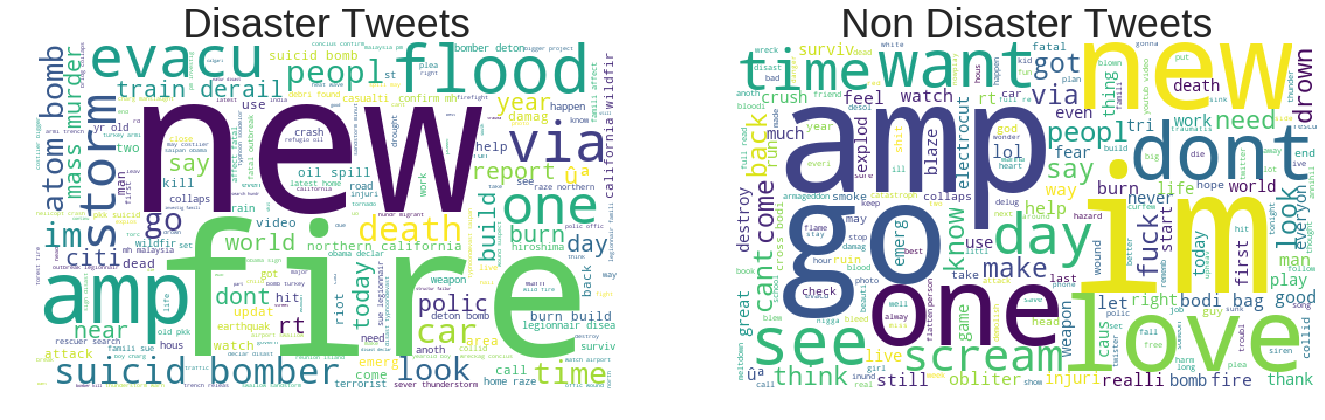

In [129]:
from wordcloud import WordCloud
fig, (ax_1, ax_2) = plt.subplots(1, 2, figsize=[23, 10])
wordcloud1 = WordCloud(background_color='white',width=500,height=300).generate(" ".join(disaster_tweets))
ax_1.imshow(wordcloud1)
ax_1.axis('off')
ax_1.set_title('Disaster Tweets',fontsize=40);

wordcloud2 = WordCloud(background_color='white',width=500,height=300).generate(" ".join(no_disaster_tweets))
ax_2.imshow(wordcloud2)
ax_2.axis('off')
ax_2.set_title('Non Disaster Tweets',fontsize=40);

# Building Text Classification models

# Change tokens into a vector
In order to build the models to predict the disaster, we need to change words into numbers. These things can be done with vectorizer functions: Countvectorizer and TfidfVectorizer

## Countvectorizer

In [130]:
count_vectorizer = CountVectorizer()
train_count = count_vectorizer.fit_transform(train['text'])
test_count = count_vectorizer.transform(test['text'])

In [131]:
# gnb = GaussianNB()
# def select_model(x,y,model):
#     scores = cross_val_score(model, x, y, cv=5, scoring='f1')
#     acc = np.mean(scores)
#     return acc
# select_model(train_count.toarray(),train['target'], gnb)

## Logistic Regression

In [132]:
logistic_count = LogisticRegression()
scores = model_selection.cross_val_score(logistic_count, train_count.toarray(), train["target"], cv=5, scoring="f1")
scores

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

array([0.58181818, 0.54844007, 0.60108443, 0.54934823, 0.69848846])

In [133]:
# logistic = LogisticRegression()
# select_model(train_count.toarray(),train['target'], logistic)

In [134]:
# multinomial_NB = MultinomialNB()
# select_model(train_count.toarray(),train['target'],multinomial_NB)

## Naives Bayes Classifier

In [135]:
multinomial_NB_count = MultinomialNB()
scores = model_selection.cross_val_score(multinomial_NB_count, train_count.toarray(), train["target"], cv=5, scoring="f1")
scores

array([0.63291139, 0.61924686, 0.6698696 , 0.64860558, 0.74808095])

In [136]:
gaussian_nb_count = GaussianNB()
scores = model_selection.cross_val_score(gaussian_nb_count, train_count.toarray(), train["target"], cv=5, scoring="f1")
scores

array([0.6326402 , 0.59484778, 0.61783816, 0.60838748, 0.59494415])

### Random Forest

In [137]:
rf_count = RandomForestClassifier(n_estimators = 10)
scores = model_selection.cross_val_score(rf_count, train_count.toarray(), train["target"], cv=5, scoring="f1")
scores

array([0.49946409, 0.44524887, 0.5302682 , 0.42698892, 0.63240418])

### XGBoost

In [138]:
# import xgboost as xgb
# clf_xgb_count = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
#                         subsample=0.8, nthread=10, learning_rate=0.1)
# scores = model_selection.cross_val_score(clf_xgb_count, train_count.toarray(), train["target"], cv=5, scoring="f1")
# scores

array([0.48218029, 0.41915086, 0.5376506 , 0.38373306, 0.56289593])

Among the models using CountVectorizer, multinomial Naives Bayes is the best model.

## TF-IDF

In [139]:
tfidf = TfidfVectorizer()
train_tfidf = tfidf.fit_transform(train['text'])
test_tfidf = tfidf.transform(test['text'])

## Logistic Regression

In [140]:
logistic_tfidf = LogisticRegression()
scores = model_selection.cross_val_score(logistic_tfidf, train_tfidf.toarray(), train["target"], cv=5, scoring="f1")
scores

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

array([0.56916996, 0.54578097, 0.58303887, 0.49895178, 0.71165644])

## Naives Bayes Classifier

In [141]:
multinomial_NB_tfidf = MultinomialNB()
scores = model_selection.cross_val_score(multinomial_NB_tfidf, train_tfidf.toarray(), train["target"], cv=5, scoring="f1")
scores

array([0.57387989, 0.60728745, 0.63877715, 0.61146497, 0.7444898 ])

In [142]:
gaussian_nb_tfidf = GaussianNB()
scores = model_selection.cross_val_score(gaussian_nb_tfidf, train_tfidf.toarray(), train["target"], cv=5, scoring="f1")
scores

array([0.61345646, 0.59786029, 0.5954488 , 0.5872818 , 0.57549505])

In [143]:
# select_model(train2.toarray(),train['target'],gnb)

In [144]:
# select_model(train2.toarray(),train['target'],lr)

In [145]:
# clf_NB = MultinomialNB()
# select_model(train1.toarray(),train['target'],clf_NB)

In [146]:
# rf = RandomForestClassifier(n_estimators = 10)
# select_model(train_tfidf.toarray(),train['target'],rf)

In [147]:
rf_tfidf = RandomForestClassifier(n_estimators = 10)
scores = model_selection.cross_val_score(rf_tfidf, train_tfidf.toarray(), train["target"], cv=5, scoring="f1")
scores

array([0.5203575 , 0.4014733 , 0.57325861, 0.45679012, 0.57404326])

In [150]:
# import xgboost as xgb
# clf_xgb_tfidf = xgb.XGBClassifier(max_depth=7, n_estimators=300, learning_rate=0.1)
# scores = model_selection.cross_val_score(clf_xgb_tfidf, train_tfidf.toarray(), train["target"], cv=5, scoring="f1")
# scores

In [151]:
multinomial_NB_count.fit(train_count.toarray(),train['target'])
predictions = multinomial_NB_count.predict(test_count.toarray())
pred[:15]

In [152]:
df_submission = {"id": test['id'],
                 "target": predictions}
submission = pd.DataFrame(df_submission)
submission.to_csv('submission_df.csv',index=False)